In [2]:
import os; import pathlib as pl ; from pprint import pformat ; import flopy ; import flopy.plot.styles as styles; import git
import matplotlib.gridspec as gridspec ; import matplotlib.pyplot as plt ; import matplotlib.ticker as mticker
import numpy as np ; import pooch ; import shapely
from flopy.discretization import VertexGrid ; from flopy.utils.triangle import Triangle ; from flopy.utils.voronoi import VoronoiGrid
from matplotlib import colors ; from modflow_devtools.misc import get_env, timed ; from shapely.geometry import LineString, Polygon

import warnings
warnings.filterwarnings(action='ignore', module='.*paramiko.*')

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

In [18]:
geometries = {
    "sv_boundary": """0.0 0.0    0.0 20000.0    12500.0 20000.0    12500.0 0.0""",    
    "sv_river": """4250.0 8750.0    4250.0 0.0""",    
    "sv_river_box": """3500.0 0.0    3500.0 9500.0    5000.0 9500.0    5000.0 0.0""",    
    "sv_wells": """7250. 17250.    7750. 2750.    2750 3750.""",    
    "sv_lake": """1500. 18500.    3500. 18500.    3500. 15500.    4000. 15500.    4000. 14500.    
    4500. 14500.    4500. 12000.    2500. 12000.    2500. 12500.    2000. 12500.    2000. 14000.    
    1500. 14000.    1500. 15000.    1000. 15000.    1000. 18000.    1500. 18000."""}

In [12]:
geometries

{'sv_boundary': '0.0 0.0 0.0 20000.0 12500.0 20000.0 12500.0 0.0',
 'sv_river': '4250.0 8750.0 4250.0 0.0',
 'sv_river_box': '3500.0 0.0 3500.0 9500.0 5000.0 9500.0 5000.0 0.0',
 'sv_wells': '7250. 17250. 7750. 2750. 2750 3750.',
 'sv_lake': '1500. 18500. 3500. 18500.\n    3500. 15500.\n    4000. 15500.\n    4000. 14500.\n    4500. 14500.\n    4500. 12000.\n    2500. 12000.\n    2500. 12500.\n    2000. 12500.\n    2000. 14000.\n    1500. 14000.\n    1500. 15000.\n    1000. 15000.\n    1000. 18000.\n    1500. 18000.'}

In [ ]:
def string2geom(geostring, conversion=None):
    if conversion is None:
        multiplier = 1.0
    else:
        multiplier = float(conversion)
    res = []
    for line in geostring.split("\n"):
        line = line.strip()
        line = line.split(" ")
        x = float(line[0]) * multiplier
        y = float(line[1]) * multiplier
        res.append((x, y))
    return res


def densify_geometry(line, step, keep_internal_nodes=True):
    xy = []  # list of tuple of coordinates
    lines_strings = []
    if keep_internal_nodes:
        for idx in range(1, len(line)):
            lines_strings.append(shapely.geometry.LineString(line[idx - 1 : idx + 1]))
    else:
        lines_strings = [shapely.geometry.LineString(line)]

    for line_string in lines_strings:
        length_m = line_string.length  # get the length
        for distance in np.arange(0, length_m + step, step):
            point = line_string.interpolate(distance)
            xy_tuple = (point.x, point.y)
            if xy_tuple not in xy:
                xy.append(xy_tuple)
        # make sure the end point is in xy
        if keep_internal_nodes:
            xy_tuple = line_string.coords[-1]
            if xy_tuple not in xy:
                xy.append(xy_tuple)

    return xy


def circle_function(center=(0, 0), radius=1.0, dtheta=10.0):
    angles=np.arange(0.0, 360.0, dtheta)*np.pi / 180.0 ;xpts=center[0] + np.cos(angles)*radius ;ypts=center[1]+np.sin(angles)*radius
    return np.array([(x, y) for x, y in zip(xpts, ypts)])


sim_name = "ex-gwt-synthetic-valley"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = pl.Path(f"../data/{sim_name}")
data_path = data_path if data_path.is_dir() else pl.Path.cwd()

# Conversion factors
ft2m = 1.0 / 3.28081
ft3tom3 = 1.0 * ft2m * ft2m * ft2m
ftpd2cmpy = 1000.0 * 365.25 * ft2m
mpd2cmpy = 100.0 * 365.25
mpd2inpy = 12.0 * 365.25 * 3.28081

### Model setup

Define functions to build models, write input files, and run the simulation.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
pertim = 10957.5  # Simulation length ($d$)
ntransport_steps = 60  # Number of transport time steps
nlay = 6  # Number of layers
rainfall = 0.0025  # Rainfall ($m/d$)
evaporation = 0.0019  # Potential evaporation ($m/d$)
sfr_length_conversion = 1.0  # SFR package length unit conversion
sfr_time_conversion = 86400.0  # SFR package time conversion
sfr_width = 3.048  # Stream width ($m$)
sfr_bedthick = 0.3048  # Stream bed thickness ($m$)
sfr_mann = 0.030  # Stream Manning's roughness coefficient
lake_bedleak = 0.0013  # Lake bed leakance ($1/d$)
lak_length_conversion = 1.0  # LAK package length unit conversion
lak_time_conversion = 86400.0  # LAK package time conversion
drn_kv = 0.03048  # Drain vertical hydraulic conductivity ($m/d$)
drn_bed_thickness = 0.3048  # Drain bed thickness ($m$)
drn_depth = 0.3048  # Drain linear scaling depth ($m$)
alpha_l = 75.0  # Longitudinal dispersivity ($m$)
alpha_th = 7.5  # Transverse horizontal dispersivity ($m$)
porosity = 0.2  # Aquifer porosity (unitless)
confining_porosity = 0.4  # Confining unit porosity (unitless)


In [3]:
# voronoi grid properties
maximum_area = 150.0 * 150.0
well_dv = 300.0
boundary_refinement = 100.0
river_refinement = 25.0
lake_refinement = 30.0
max_boundary_area = boundary_refinement * boundary_refinement
max_river_area = river_refinement * river_refinement
max_lake_area = lake_refinement * lake_refinement

boundary_polygon = string2geom(geometries["sv_boundary"], conversion=ft2m)
bp = np.array(boundary_polygon)
bp_densify = np.array(densify_geometry(bp, boundary_refinement))

river_polyline = string2geom(geometries["sv_river"], conversion=ft2m)
sg = np.array(river_polyline)
sg_densify = np.array(densify_geometry(sg, river_refinement))

river_boundary = string2geom(geometries["sv_river_box"], conversion=ft2m)
rb = np.array(river_boundary)
rb_densify = np.array(densify_geometry(rb, river_refinement))

lake_polygon = string2geom(geometries["sv_lake"], conversion=ft2m)
lake_plot = string2geom(geometries["sv_lake"], conversion=ft2m)
lake_plot += [lake_plot[0]]
lake_plot = np.array(lake_plot)
lp = np.array(lake_polygon)
lp_densify = np.array(densify_geometry(lp, lake_refinement))

well_points = string2geom(geometries["sv_wells"], conversion=ft2m)
wp = np.array(well_points)

In [4]:
# create the voronoi grid
temp_path = pl.Path("temp/triangle_data")
temp_path.mkdir(parents=True, exist_ok=True)
tri = Triangle(angle=30, nodes=sg_densify, model_ws=temp_path)
tri.add_polygon(bp_densify)
tri.add_polygon(rb_densify)
tri.add_polygon(lp_densify)
tri.add_region((10, 10), attribute=10, maximum_area=max_boundary_area)
tri.add_region((3050.0, 3050.0), attribute=10, maximum_area=max_boundary_area)
tri.add_region((900.0, 4600.0), attribute=11, maximum_area=max_lake_area)
tri.add_region((1200.0, 150.0), attribute=10, maximum_area=max_river_area)
for idx, w in enumerate(wp):
    center = (w[0], w[1])
    tri.add_polygon(circle_function(center=center, radius=100.0))
    tri.add_region(center, attribute=idx, maximum_area=500.0)
tri.build(verbose=False)
vor = VoronoiGrid(tri)

In [5]:
# create a vertex grid from the voronoi grid
gridprops = vor.get_gridprops_vertexgrid()
idomain_vor = np.ones((1, vor.ncpl), dtype=int)
voronoi_grid = VertexGrid(**gridprops, nlay=1, idomain=idomain_vor)

In [6]:
# load raster data files
fname = "k_aq_SI.tif"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:d233e5c393ab6c029c63860d73818856",
)
kaq = flopy.utils.Raster.load(fpath)

fname = "k_clay_SI.tif"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:a08999c37f42b35884468e4ef896d5f9",
)
kclay = flopy.utils.Raster.load(fpath)

fname = "top_SI.tif"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:781155bdcc2b9914e1cad6b10de0e9c7",
)
top_base = flopy.utils.Raster.load(fpath)

fname = "bottom_SI.tif"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:00b4a39fbf5180e65c0367cdb6f15c93",
)
bot = flopy.utils.Raster.load(fpath)

fname = "lake_location_SI.tif"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:38600d6f0eef7c033ede278252dc6343",
)
lake_location = flopy.utils.Raster.load(fpath)

In [7]:
# a few variables for plotting
xcv, ycv = voronoi_grid.xcellcenters, voronoi_grid.ycellcenters
x0 = x1 = sg[:, 0].min()
y0, y1 = sg[:, 1].max(), sg[:, 1].min()
top_range = (0, 20)
top_levels = np.arange(0, 25, 5)
head_range = (-1, 5)
head_levels = np.arange(1, head_range[1] + 1, 1)
extent = voronoi_grid.extent

In [8]:
# intersect the rasters with the vertex grid
top_vg = top_base.resample_to_grid(
    voronoi_grid, band=top_base.bands[0], method="linear", extrapolate_edges=True
)
bot_vg = bot.resample_to_grid(
    voronoi_grid, band=bot.bands[0], method="linear", extrapolate_edges=True
)
lake_cells_vg = lake_location.resample_to_grid(
    voronoi_grid, band=lake_location.bands[0], method="nearest", extrapolate_edges=True
)
kaq_vg = kaq.resample_to_grid(
    voronoi_grid, band=kaq.bands[0], method="nearest", extrapolate_edges=True
)
kclay_vg = kclay.resample_to_grid(voronoi_grid, band=kclay.bands[0], method="nearest")

In [9]:
# create confining unit location map
kclay_loc_vg = np.zeros(kclay_vg.shape, dtype=int)
kclay_loc_vg[kclay_vg < 60.0] = 1
idomain_2 = np.ones(kclay_vg.shape, dtype=int)
idomain_2[kclay_loc_vg == 0] = -1

# set the porosity based on the clay location
porosity_2 = np.full(kclay_vg.shape, porosity, dtype=float)
porosity_2[kclay_loc_vg == 1] = confining_porosity

In [10]:
# set the bottom of each layer
bot_l2 = np.full(bot_vg.shape, -51.0 * ft2m, dtype=float)
bot_l3 = np.full(bot_vg.shape, -100.0 * ft2m, dtype=float)
bot_l4 = bot_vg + 0.5 * (bot_l3 - bot_vg)
# set the bottom of the 3rd layer in areas where the confining unit exists
bot_l2[idomain_2 == -1] = -50.0 * ft2m
# create a list with bottom data
botm = [-5.0 * ft2m, -50.0 * ft2m, bot_l2, -100.0 * ft2m, bot_l4, bot_vg]

In [11]:
# create a modelgrid for the lake
lake_grid_top = np.full((vor.ncpl), 50.0, dtype=float)
lake_vg_grid = flopy.discretization.VertexGrid(
    **gridprops,
    nlay=1,
    idomain=idomain_vor,
    top=lake_grid_top,
    botm=top_vg.reshape(1, vor.ncpl),
)

In [12]:
# intersect stream features with the grid
ixs = flopy.utils.GridIntersect(voronoi_grid, method="vertex")
sg_result = ixs.intersect(LineString(sg_densify), sort_by_cellid=False)

# build sfr package datasets
sfr_plt_array = np.zeros(voronoi_grid.ncpl, dtype=int)
sfr_nodes = np.arange(0, sg_result.shape[0])
gwf_nodes = sg_result["cellids"][::-1]
sfr_lengths = sg_result["lengths"][::-1]
total_cond = 1800000.0 * ft3tom3
sfr_hk = total_cond * sfr_bedthick / (sfr_width * sfr_lengths.sum())
b0, b1 = -0.3 * ft2m, -2.05 * ft2m
sfr_slope = -0.0002
cum_dist = np.zeros(sfr_nodes.shape, dtype=float)
cum_dist[0] = 0.5 * sfr_lengths[0]
for idx in range(1, sfr_nodes.shape[0]):
    cum_dist[idx] = cum_dist[idx - 1] + 0.5 * (sfr_lengths[idx - 1] + sfr_lengths[idx])
sfr_bot = b0 + sfr_slope * cum_dist
sfr_conn = []
for idx, node in enumerate(sfr_nodes):
    iconn = [node]
    if idx > 0:
        iconn.append(sfr_nodes[idx - 1])
    if idx < sfr_nodes.shape[0] - 1:
        iconn.append(-sfr_nodes[idx + 1])
    sfr_conn.append(iconn)

# <rno> <cellid(ncelldim)> <rlen> <rwid> <rgrd> <rtp> <rbth> <rhk> <man> <ncon> <ustrf> <ndv>
sfrpak_data = []
for idx, (cellid, rlen, rtp) in enumerate(zip(gwf_nodes, sfr_lengths, sfr_bot)):
    sfr_plt_array[cellid] = 1
    sfrpak_data.append(
        (
            idx,
            (0, cellid),
            rlen,
            sfr_width,
            -sfr_slope,
            rtp,
            sfr_bedthick,
            sfr_hk,
            sfr_mann,
            (len(sfr_conn[idx]) - 1),
            1.0,
            0,
        )
    )
sfr_spd = [(node, "rainfall", rainfall) for node in sfr_nodes] + [
    (node, "evaporation", evaporation) for node in sfr_nodes
]

In [13]:
# build lake package datasets
lake_ic = 11.3 * ft2m
idx = np.where(lake_cells_vg == 1.0)

lake_map = np.ones(voronoi_grid.ncpl, dtype=int) * -1
lake_map[idx] = 0

(idomain, lakpak_dict, lak_connections) = flopy.mf6.utils.get_lak_connections(
    voronoi_grid, lake_map, bedleak=lake_bedleak
)

# add concentration to lake data as aux
lakpak_data = [(0, lake_ic, lakpak_dict[0], 1.0)]
lake_spd = [
    (0, "rainfall", rainfall),
    (0, "evaporation", evaporation),
]

In [14]:
# build drain package datasets
areas = []
for idx in range(voronoi_grid.ncpl):
    vertices = np.array(voronoi_grid.get_cell_vertices(idx))
    area = Polygon(vertices).area
    areas.append(area)
drn_spd = []
for idx, elev in enumerate(top_vg):
    if lake_cells_vg[idx] > 0:
        cond = drn_kv * areas[idx] / drn_bed_thickness
        drn_spd.append([(0, idx), elev, cond, -drn_depth])

In [15]:
# build well package datasets
well_loc = []
for x, y in well_points:
    well_loc.append(voronoi_grid.intersect(x, y))

# first well is Virginia City well site 2
# second well is Reilly well
# third well is Virginia City well site 1
well_boundnames = ["P3", "P1", "P2"]
rates = [-1900.0, -7600.0, -7600.0]
welspd = [
    [nlay - 1, cellid, rates[idx], well_boundnames[idx]]
    for idx, cellid in enumerate(well_loc)
]

### Model setup

Define functions to build models, write input files, and run the simulation.

In [16]:
def build_mf6gwf(sim_folder):
    print(f"Building mf6gwf model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwf")
    sim = flopy.mf6.MFSimulation(
        sim_name=name,
        sim_ws=sim_ws,
        exe_name="mf6",
        continue_=True,
    )
    tdis = flopy.mf6.ModflowTdis(sim, time_units="days", perioddata=((pertim, 1, 1.0),))
    ims = flopy.mf6.ModflowIms(
        sim,
        print_option="all",
        complexity="simple",
        linear_acceleration="bicgstab",
    )
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=name,
        save_flows=True,
        newtonoptions="NEWTON UNDER_RELAXATION",
    )
    dis = flopy.mf6.ModflowGwfdisv(
        gwf,
        length_units="meters",
        nlay=nlay,
        ncpl=vor.ncpl,
        nvert=vor.nverts,
        top=top_vg,
        botm=botm,
        vertices=vor.get_disv_gridprops()["vertices"],
        cell2d=vor.get_disv_gridprops()["cell2d"],
        idomain=[1, 1, idomain_2, 1, 1, 1],
    )
    ic = flopy.mf6.ModflowGwfic(gwf, strt=11.0)
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        xt3doptions=True,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=[1, 0, 0, 0, 0, 0],
        k=[kaq_vg, kaq_vg, kclay_vg, kaq_vg, kaq_vg, kaq_vg],
        k33=[
            0.25 * kaq_vg,
            0.25 * kaq_vg,
            kclay_vg,
            0.25 * kaq_vg,
            0.25 * kaq_vg,
            0.25 * kaq_vg,
        ],
    )
    rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rainfall)
    evt = flopy.mf6.ModflowGwfevta(gwf, surface=top_vg, rate=evaporation, depth=1.0)
    wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=welspd, boundnames=True)
    drn = flopy.mf6.ModflowGwfdrn(
        gwf,
        auxiliary=["depth"],
        auxdepthname="depth",
        stress_period_data=drn_spd,
    )
    sfr = flopy.mf6.ModflowGwfsfr(
        gwf,
        print_stage=True,
        print_flows=True,
        length_conversion=sfr_length_conversion,
        time_conversion=sfr_time_conversion,
        stage_filerecord=f"{name}.sfr.stage.bin",
        budget_filerecord=f"{name}.sfr.cbc",
        nreaches=len(sfrpak_data),
        packagedata=sfrpak_data,
        connectiondata=sfr_conn,
        perioddata=sfr_spd,
    )
    lak = flopy.mf6.ModflowGwflak(
        gwf,
        pname="LAK-1",
        time_conversion=lak_time_conversion,
        length_conversion=lak_length_conversion,
        auxiliary=["concentration"],
        print_stage=True,
        print_flows=True,
        stage_filerecord=f"{name}.lak.stage.bin",
        budget_filerecord=f"{name}.lak.cbc",
        nlakes=1,
        packagedata=lakpak_data,
        connectiondata=lak_connections,
        perioddata=lake_spd,
    )
    oc = flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=name + ".hds",
        budget_filerecord=name + ".cbc",
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("BUDGET", "ALL")],
    )
    return sim


def build_mf6gwt(sim_folder):
    print(f"Building mf6gwt model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwt")
    sim = flopy.mf6.MFSimulation(
        sim_name=name,
        sim_ws=sim_ws,
        exe_name="mf6",
        continue_=True,
    )
    tdis = flopy.mf6.ModflowTdis(
        sim, time_units="days", perioddata=((pertim, ntransport_steps, 1.0),)
    )
    ims = flopy.mf6.ModflowIms(
        sim,
        print_option="all",
        complexity="simple",
        linear_acceleration="bicgstab",
    )
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name)
    dis = flopy.mf6.ModflowGwtdisv(
        gwt,
        length_units="meters",
        nlay=nlay,
        ncpl=vor.ncpl,
        nvert=vor.nverts,
        top=top_vg,
        botm=botm,
        vertices=vor.get_disv_gridprops()["vertices"],
        cell2d=vor.get_disv_gridprops()["cell2d"],
        idomain=[1, 1, idomain_2, 1, 1, 1],
    )
    ic = flopy.mf6.ModflowGwtic(gwt, strt=0.0)
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme="tvd")
    dsp = flopy.mf6.ModflowGwtdsp(
        gwt,
        diffc=0.0e-12,
        alh=alpha_l,
        ath1=alpha_th,
    )
    mst = flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=[
            porosity_2,
            porosity,
            porosity_2,
            porosity,
            porosity,
            porosity,
        ],
    )
    pd = [
        ("GWFHEAD", "../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.cbc", None),
    ]
    fmi = flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)
    sourcerecarray = [
        ("LAK-1", "AUX", "CONCENTRATION"),
    ]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)

    oc = flopy.mf6.ModflowGwtoc(
        gwt,
        concentration_filerecord=f"{name}.ucn",
        saverecord=[("CONCENTRATION", "LAST")],
        printrecord=[("BUDGET", "ALL")],
    )
    return sim


def build_models(sim_name):
    sim_mf6gwf = build_mf6gwf(sim_name)
    sim_mf6gwt = build_mf6gwt(sim_name)
    sim_mf2005 = None  # build_mf2005(sim_name)
    sim_mt3dms = None  # build_mt3dms(sim_name, sim_mf2005)
    return sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms


def write_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    sim_mf6gwf.write_simulation(silent=silent)
    sim_mf6gwt.write_simulation(silent=silent)


@timed
def run_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    success, buff = sim_mf6gwf.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mf6gwt.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [17]:
# Figure properties
two_panel_figsize = (17.15 / 2.541, 0.8333 * 17.15 / 2.541)
one_panel_figsize = (8.25 / 2.541, 13.25 / 2.541)
six_panel_figsize = (17.15 / 2.541, 1.4 * 0.8333 * 17.15 / 2.541)
levels = np.arange(10, 110, 10)
contour_color = "black"
contour_style = "--"
sv_contour_dict = {
    "linewidths": 0.5,
    "colors": contour_color,
    "linestyles": contour_style,
}
sv_contour_dict = {
    "linewidths": 0.5,
    "colors": contour_color,
    "linestyles": contour_style,
}
sv_gwt_contour_dict = {
    "linewidths": 0.75,
    "colors": contour_color,
    "linestyles": contour_style,
}
contour_label_dict = {
    "linewidth": 0.5,
    "color": contour_color,
    "linestyle": contour_style,
}
contour_gwt_label_dict = {
    "linewidth": 0.75,
    "color": contour_color,
    "linestyle": contour_style,
}
clabel_dict = {"inline": True, "fmt": "%1.0f", "fontsize": 6, "inline_spacing": 0.5}
font_dict = {"fontsize": 5, "color": "black"}
grid_dict = {"lw": 0.25, "color": "0.5"}
arrowprops = dict(arrowstyle="-", edgecolor="red", lw=0.5, shrinkA=0.15, shrinkB=0.15)
river_dict = {"color": "blue", "linestyle": "-", "linewidth": 1}
lake_cmap = colors.ListedColormap(["cyan"])
clay_cmap = colors.ListedColormap(["brown"])


def plot_wells(ax=None, ms=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(wp[:, 0], wp[:, 1], "ro", ms=ms)
    return ax


def plot_river(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(sg_densify[:, 0], sg_densify[:, 1], **river_dict)
    return ax


def plot_lake(ax=None, lw=0.5, color="cyan", marker=None, densify=False):
    if ax is None:
        ax = plt.gca()
    if densify:
        arr = lp_densify
    else:
        arr = lake_plot
    ax.plot(arr[:, 0], arr[:, 1], ls="-", color=color, lw=lw, marker=marker)
    return ax


def set_ticklabels(
    ax,
    fmt="{:.1f}",
    skip_xticklabels=False,
    skip_yticklabels=False,
    skip_xlabel=False,
    skip_ylabel=False,
    xticks=None,
    yticks=None,
):
    if xticks is None:
        labels = [ax.get_xticks().tolist()]
    else:
        ax.set_xticks(xticks, labels=[str(value) for value in xticks])
        labels = [xticks]

    if yticks is None:
        labels += [ax.get_yticks().tolist()]
    else:
        ax.set_yticks(yticks, labels=[str(value) for value in yticks])
        labels += [yticks]

    for idx, label in enumerate(labels):
        for jdx, value in enumerate(label):
            labels[idx][jdx] = fmt.format(float(value) / 1000.0)

    if skip_xticklabels:
        ax.set_xticklabels([])
    else:
        ax.xaxis.set_major_locator(mticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels(labels[0])

    if skip_yticklabels:
        ax.set_yticklabels([])
    else:
        ax.yaxis.set_major_locator(mticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(labels[1])

    if not skip_xlabel:
        ax.set_xlabel("x position (km)")
    if not skip_ylabel:
        ax.set_ylabel("y position (km)")


def plot_well_labels(ax):
    for xy, name in zip(well_points, well_boundnames):
        styles.add_annotation(
            ax=ax,
            text=name,
            xy=xy,
            xytext=(-15, 10),
            bold=False,
            textcoords="offset points",
            arrowprops=arrowprops,
        )


def plot_feature_labels(ax):
    styles.add_text(
        ax=ax,
        text="Blue\nLake",
        x=610,
        y=5000.0,
        transform=False,
        bold=False,
        ha="center",
        va="center",
    )
    styles.add_text(
        ax=ax,
        text="Straight River",
        x=1425,
        y=1500.0,
        transform=False,
        bold=False,
        va="center",
        ha="center",
        rotation=90,
    )
    plot_well_labels(ax)


def plot_results(sims, idx):
    print("Plotting model results...")
    plot_river_mapping(sims, idx)
    plot_head_results(sims, idx)
    plot_conc_results(sims)


def plot_river_mapping(sims, idx):
    print("Plotting river mapping...")
    sim_mf6gwf, _, _, _ = sims
    sim_ws = sim_mf6gwf.simulation_data.mfpath.get_sim_path()
    dv = 100.0  # m

    with styles.USGSMap():
        fig = plt.figure(figsize=one_panel_figsize, constrained_layout=False)
        gs = gridspec.GridSpec(ncols=1, nrows=24, figure=fig)
        ax0 = fig.add_subplot(gs[:18])
        ax_leg = fig.add_subplot(gs[18:])

        ax = ax0
        ax.set_aspect("equal", "box")
        mm = flopy.plot.PlotMapView(modelgrid=voronoi_grid, ax=ax)
        mm.plot_array(kclay_loc_vg, masked_values=[0], cmap=clay_cmap, alpha=0.5)
        mm.plot_array(lake_cells_vg, masked_values=[0], cmap=lake_cmap, alpha=0.5)
        mm.plot_grid(**grid_dict)
        plot_river(ax)
        plot_wells(ax, ms=3)
        plot_feature_labels(ax)

        xticks = np.arange(mm.extent[0], mm.extent[1], 1000.0).tolist()
        yticks = np.arange(mm.extent[2], mm.extent[3], 1000.0).tolist()
        set_ticklabels(ax, fmt="{:.0f}", xticks=xticks, yticks=yticks)

        # legend
        ax = ax_leg
        xy0 = (-100, -100)
        ax.set_ylim(0, 1)
        ax.set_axis_off()

        # fake data to set up legend
        ax.plot(
            xy0,
            xy0,
            lw=0.0,
            marker=".",
            ms=5,
            mfc="red",
            mec="none",
            mew=0.0,
            label="Well",
        )
        ax.plot(
            xy0,
            xy0,
            lw=0.0,
            marker="s",
            mfc="cyan",
            mec="black",
            mew=0.5,
            alpha=0.5,
            label="Lake",
        )
        ax.plot(
            xy0,
            xy0,
            lw=0.0,
            marker="s",
            mfc="brown",
            mec="black",
            mew=0.5,
            alpha=0.5,
            label="Confining unit",
        )
        ax.axhline(xy0[0], **river_dict, label="River")
        styles.graph_legend(
            ax,
            ncol=2,
            loc="lower center",
            labelspacing=0.1,
            columnspacing=0.6,
            handletextpad=0.3,
        )

        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.basename(os.path.split(sim_ws)[0])
            fname = f"{sim_folder}-river-discretization.png"
            fig.savefig(figs_path / fname)


def plot_head_results(sims, idx):
    print("Plotting gwf model results...")
    sim_mf6gwf, _, _, _ = sims
    sim_ws = sim_mf6gwf.simulation_data.mfpath.get_sim_path()
    gwf = sim_mf6gwf.flow

    xlims = (extent[0], extent[1])
    ylims = (extent[2], extent[3])

    p2_loc = tuple(welspd[-1][0:2])
    p2_z = gwf.modelgrid.zcellcenters[p2_loc]

    head = gwf.output.head().get_data().squeeze()
    cbc = gwf.output.budget()
    spdis = cbc.get_data(text="DATA-SPDIS")[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
        spdis, gwf, head=head
    )
    lake_q = cbc.get_data(text="LAK", full3D=True)[0]
    lake_q_dir = np.zeros(lake_q.shape, dtype=int)
    lake_q_dir[lake_q < 0.0] = -1
    lake_q_dir[lake_q > 0.0] = 1

    lake_stage = float(gwf.lak.output.stage().get_data().squeeze())
    lake_stage_vg = np.full(vor.ncpl, 1e30, dtype=float)
    idx = (lake_stage > top_vg) & (lake_cells_vg > 0)
    lake_stage_vg[idx] = lake_stage

    with styles.USGSMap():
        fig = plt.figure(figsize=two_panel_figsize, constrained_layout=True)
        gs = gridspec.GridSpec(ncols=2, nrows=24, figure=fig)
        ax0 = fig.add_subplot(gs[:22, 0])
        ax1 = fig.add_subplot(gs[:22, 1])
        ax2 = fig.add_subplot(gs[22:, :])

        xticks = np.arange(extent[0], extent[1], 1000.0).tolist()
        yticks = np.arange(extent[2], extent[3], 1000.0).tolist()

        for ax in (ax0, ax1):
            ax.set_xlim(xlims)
            ax.set_xticks(xticks)
            ax.set_ylim(ylims)
            ax.set_yticks(yticks)
            ax.set_aspect("equal", "box")

        # topography
        ax = ax0
        styles.heading(ax=ax, idx=0)
        mm = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=voronoi_grid.extent)
        cb = mm.plot_array(top_vg, vmin=top_range[0], vmax=top_range[1])
        mm.plot_grid(**grid_dict)
        plot_wells(ax=ax, ms=3)
        plot_river(ax=ax)
        plot_lake(ax=ax)
        cs = mm.contour_array(top_vg, **sv_contour_dict, levels=top_levels)
        ax.clabel(cs, **clabel_dict)
        set_ticklabels(ax, fmt="{:.0f}")

        # topography colorbar
        cbar = plt.colorbar(cb, ax=ax, orientation="horizontal", shrink=0.65)
        cbar.ax.tick_params(
            labelsize=5, labelcolor="black", color="black", length=6, pad=2
        )
        cbar.ax.set_title("Elevation (m)", pad=2.5, loc="left", fontdict=font_dict)

        # head
        ax = ax1
        styles.heading(ax=ax, idx=1)
        mm = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=voronoi_grid.extent)
        cb = mm.plot_array(head, vmin=head_range[0], vmax=head_range[1])

        mm.plot_grid(**grid_dict)
        q = mm.plot_vector(qx, qy, normalize=False)
        qk = plt.quiverkey(
            q,
            -0.35,
            -0.31,
            1.0,
            label="Specific discharge vector",
            labelsep=0.05,
            labelpos="E",
            labelcolor="black",
            fontproperties={"size": 9, "weight": "bold"},
        )

        plot_wells(ax=ax, ms=3)
        plot_river(ax=ax)
        plot_lake(ax=ax)
        cs = mm.contour_array(head, **sv_contour_dict, levels=head_levels)
        ax.clabel(cs, **clabel_dict)
        set_ticklabels(ax, fmt="{:.0f}", xticks=xticks, yticks=yticks)

        # head colorbar
        cbar = plt.colorbar(cb, ax=ax, orientation="horizontal", shrink=0.65)
        cbar.ax.tick_params(
            labelsize=5, labelcolor="black", color="black", length=6, pad=2
        )
        cbar.ax.set_title("Head (m)", pad=2.5, loc="left", fontdict=font_dict)

        # legend
        ax = ax2
        xy0 = (-100, -100)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_axis_off()

        # fake data to set up legend
        well_patch = ax.plot(
            xy0,
            xy0,
            lw=0.0,
            marker=".",
            ms=5,
            mfc="red",
            mec="none",
            mew=0.0,
            label="Well",
        )
        lake_patch = ax.axhline(xy0[0], color="cyan", lw=0.5, label="Lake")
        river_patch = ax.axhline(xy0[0], **river_dict, label="River")
        contour_patch = ax.axhline(
            xy0[0], **contour_label_dict, label="Contour line (m)"
        )
        styles.graph_legend(
            ax,
            ncol=3,
            loc="lower center",
            labelspacing=0.1,
            columnspacing=0.6,
            handletextpad=0.3,
        )

        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.basename(os.path.split(sim_ws)[0])
            fname = f"{sim_folder}-head.png"
            fig.savefig(figs_path / fname)


def plot_conc_results(sims):
    print("Plotting gwt model results...")
    _, sim_mf6gwt, _, _ = sims
    sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
    gwt = sim_mf6gwt.trans
    with styles.USGSMap():
        fig = plt.figure(figsize=six_panel_figsize, constrained_layout=True)
        gs = gridspec.GridSpec(ncols=3, nrows=24, figure=fig)
        ax0 = fig.add_subplot(gs[:11, 0])
        ax1 = fig.add_subplot(gs[:11, 1])
        ax2 = fig.add_subplot(gs[:11, 2])
        ax3 = fig.add_subplot(gs[11:22, 0])
        ax4 = fig.add_subplot(gs[11:22, 1])
        ax5 = fig.add_subplot(gs[11:22, 2])
        ax6 = fig.add_subplot(gs[22:, :])

        axs = [ax0, ax1, ax2, ax3, ax4, ax5]

        times = gwt.output.concentration().get_times()
        conc = gwt.output.concentration().get_data(totim=times[-1])

        for k in range(6):
            ax = axs[k]
            ax.set_title(f"Layer {k + 1}")
            mm = flopy.plot.PlotMapView(
                model=gwt, ax=ax, extent=gwt.modelgrid.extent, layer=k
            )

            xticks = np.arange(extent[0], extent[1], 1000.0).tolist()
            yticks = np.arange(extent[2], extent[3], 1000.0).tolist()

            mm.plot_grid(**grid_dict)

            # plot confining unit
            if k == 2:
                mm.plot_array(
                    kclay_loc_vg, masked_values=[0], cmap=clay_cmap, alpha=0.5
                )
            plot_river(ax=ax)
            plot_lake(ax=ax)
            if k == nlay - 1:
                plot_wells(ax=ax, ms=3)
                plot_well_labels(ax)
            cs = mm.contour_array(
                conc,
                masked_values=[0],
                levels=[0.001, 0.01, 0.1, 1],
                **sv_gwt_contour_dict,
            )

            ax.clabel(cs, inline=True, fmt="%1.3g", fontsize=6, inline_spacing=0.5)

            set_ticklabels(ax, fmt="{:.0f}", xticks=xticks, yticks=yticks)

            styles.heading(ax, idx=k)

        # legend
        ax = ax6
        xy0 = (-100, -100)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_axis_off()

        # fake data to set up legend
        ax.plot(
            xy0,
            xy0,
            lw=0.0,
            marker=".",
            ms=5,
            mfc="red",
            mec="none",
            mew=0.0,
            label="Well",
        )
        ax.axhline(xy0[0], color="cyan", lw=0.5, label="Lake")
        ax.axhline(xy0[0], **river_dict, label="River")
        ax.axhline(xy0[0], **contour_gwt_label_dict, label="Concentration (mg/L)")
        ax.plot(
            xy0,
            xy0,
            lw=0.0,
            marker="s",
            mfc="brown",
            mec="black",
            mew=0.5,
            alpha=0.5,
            label="Confining unit",
        )
        styles.graph_legend(
            ax,
            ncol=5,
            loc="lower center",
            labelspacing=0.1,
            columnspacing=0.6,
            handletextpad=0.3,
            frameon=False,
        )

        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-conc.png"
            fig.savefig(figs_path / fname)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building mf6gwf model...ex-gwt-synthetic-valley


Building mf6gwt model...ex-gwt-synthetic-valley


run_models took 33280.74 ms
Plotting model results...
Plotting river mapping...


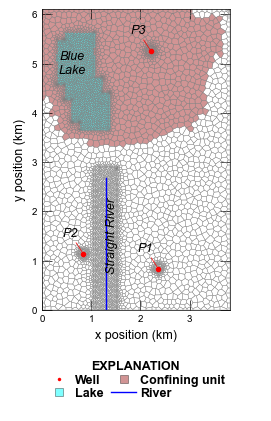

Plotting gwf model results...


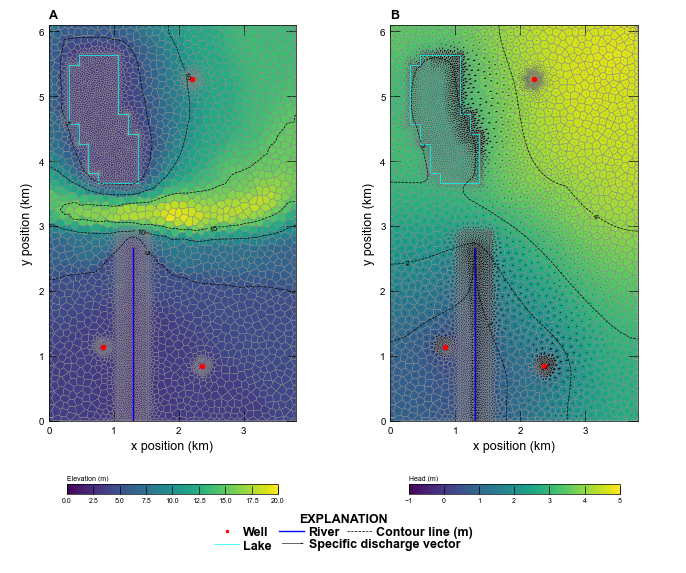

Plotting gwt model results...


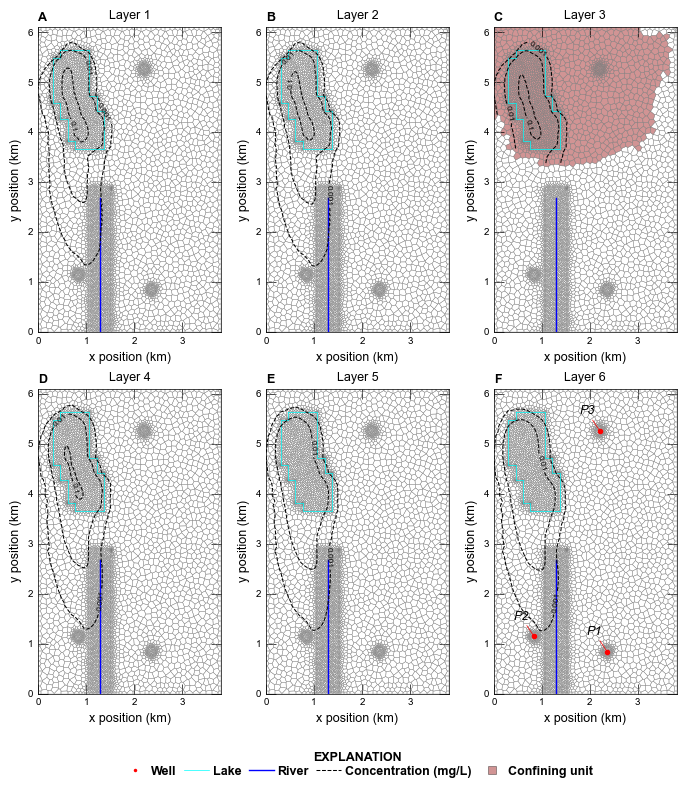

In [18]:
def scenario(idx, silent=True):
    sim = build_models(sim_name)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, idx)


scenario(0)